<a href="https://www.kaggle.com/code/lakshmipriya190803/reddit-comments-analysis-using-nlp-and-dl?scriptVersionId=163272548" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Welcome :)

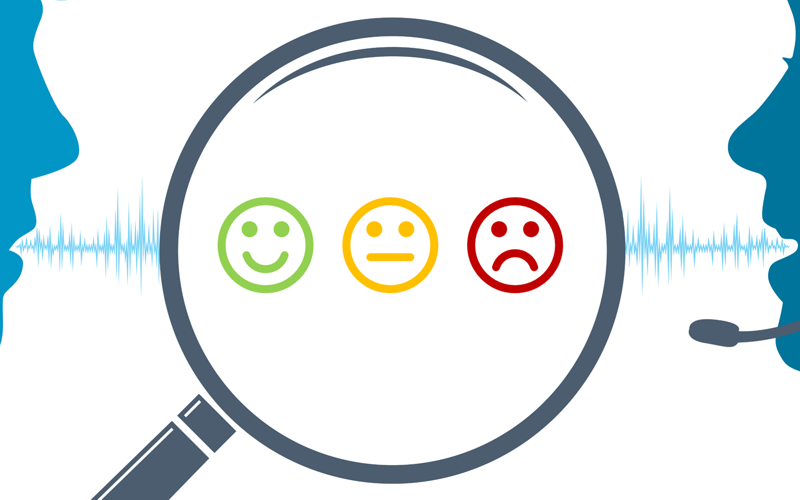

Let's explore Reddit Comments Sentiment Analysis using Machine Learning and Deep Learning. 

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is essential for effective sentiment analysis. It helps understand sentiment label distribution, identify text preprocessing needs, and select relevant features. EDA also addresses imbalanced classes, detects outliers, and visualizes data trends. This process enhances model interpretability and ensures robust sentiment analysis by informing decisions on preprocessing steps, feature selection, and model design.

In [1]:
!pip install vaderSentiment
!pip install twython
!pip install keras
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56438 sha256=4fba7b47e6341e807ba7de851ca6afaeca7fcec6900320e0b423b595a7b4cf0f
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
import pandas as pd 
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

from nltk.tokenize import RegexpTokenizer
import re
import string


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


from keras.preprocessing import sequence, text
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential


from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
#from keras.utils.module_utils import tensorflow as tf
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
df_1 = pd.read_csv("/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv")
df_1.head(5)

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [5]:
df_1.describe()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
count,52413,52415,52415,52415,52415
unique,29712,52413,22596,51042,5
top,0,comment_id,t3_107vs7i,[deleted],r/ChatGPT
freq,4,3,239,661,29711


In [6]:
print(f"Null values ? \n{df_1.isnull().sum()}")

Null values ? 
Unnamed: 0           3
comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64


In [7]:
print("since we've got some null values, let's remove that first")
df_1.dropna(inplace = True)
df_1.isna().sum()
print(f"Null values ? \n{df_1.isnull().sum()}")

since we've got some null values, let's remove that first
Null values ? 
Unnamed: 0           0
comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
dtype: int64


so far we can see the first column just contains the index, we've got id of the person commenting, what they've commented and the subreddit, NO *labels*

there are so many patterns we could look for
is there any relation between the average sentiment of comments and subreddits?
how is the overall sentiment of comments

My overall focus is going to be on comments themselves so commenter's id will be irrelevant
Although one thing I might go on look further a person would be whether they were siding with the group and how many were like them or whether their opinions stayed constant throughout subreddits 
this will be something i would look at, at the very last obviously!


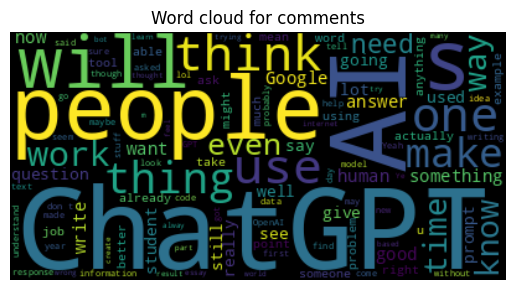

In [8]:
comments = df_1['comment_body']
text = ' '.join(comments.astype(str).tolist())

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for comments")
plt.show()

## Data Preparation

Okay from now on I will be focusing entirely on the 'Comment body' 
We do not have labels so there's two things we could do:

1. Go unsupervised
2. Use sentiment analysers to give a rating to each comment based on lexicon

Let's try both and see where we go
Either way the data needs to be cleaned before we proceed further

## Applying Vader Sentiment Analysis to obtain Labels

VADER SENTIMENT ANALYSIS SCORES are affected by factors like punctuations,capitalization,preceeding-trigrams,degree modifiers,conjunctions etc.

So without Data Preparation, we will apply VADER 

In [9]:
len(df_1['comment_body'])

52412

In [10]:
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text
    


df_1['comment_body'] = df_1['comment_body'].apply(lambda x:clean(x))
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
scores=[]
for index, row in df_1.dropna().iterrows():
    score = analyser.polarity_scores(row['comment_body'])
    score=score['compound']
    scores.append(score)
    
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
        
df_1['sentiment']=pd.Series(np.array(sentiment))

In [11]:
df_1.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,sentiment
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,Negative
1,1,iztn0q0,t3_zj2aeu,I am so angry right now. I just wasted my tim...,r/ChatGPT,Negative
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,Neutral
4,4,izu2as9,t3_zj2aeu,"Certified /, must-see moment. It really did sh...",r/ChatGPT,Negative


## Data Prep using Stemming and Lemmatizing 

In [12]:
df = df_1
df.drop(['Unnamed: 0', 'comment_id', 'comment_parent_id'], inplace = True, axis = 1)
df.head()

,comment_body,subreddit,sentiment
0,"I've been shocked for days now, I don't need c...",r/ChatGPT,Negative
1,I am so angry right now. I just wasted my tim...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,"Worked on me, ngl.",r/ChatGPT,Neutral
4,"Certified /, must-see moment. It really did sh...",r/ChatGPT,Negative


In [13]:
#converting all text to lowercase
df['comment_body'] = df['comment_body'].str.lower()
df.head(5)

,comment_body,subreddit,sentiment
0,"i've been shocked for days now, i don't need c...",r/ChatGPT,Negative
1,i am so angry right now. i just wasted my tim...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,"worked on me, ngl.",r/ChatGPT,Neutral
4,"certified /, must-see moment. it really did sh...",r/ChatGPT,Negative


In [14]:
#cleaning and removing stopwords
stopwords_list = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_list])

df['comment_body'] = df['comment_body'].apply(lambda text : cleaning_stopwords(text))
df.head()

,comment_body,subreddit,sentiment
0,"i've shocked days now, need clickbait.",r/ChatGPT,Negative
1,angry right now. wasted time reading post sub ...,r/ChatGPT,Negative
2,chatgpt karma whoring folks! think stream thou...,r/ChatGPT,Negative
3,"worked me, ngl.",r/ChatGPT,Neutral
4,"certified /, must-see moment. really shock core.",r/ChatGPT,Negative


In [15]:
#cleaning and removing punctuations 
english_punctuations = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('','', english_punctuations)
    return text.translate(translator)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_punctuations(x))
df.head(5)

,comment_body,subreddit,sentiment
0,ive shocked days now need clickbait,r/ChatGPT,Negative
1,angry right now wasted time reading post sub c...,r/ChatGPT,Negative
2,chatgpt karma whoring folks think stream thoug...,r/ChatGPT,Negative
3,worked me ngl,r/ChatGPT,Neutral
4,certified mustsee moment really shock core,r/ChatGPT,Negative


In [16]:
#cleaning and removing repeating characters:

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_repeating_char(x))
df.head()

,comment_body,subreddit,sentiment
0,ive shocked days now ned clickbait,r/ChatGPT,Negative
1,angry right now wasted time reading post sub c...,r/ChatGPT,Negative
2,chatgpt karma whoring folks think stream thoug...,r/ChatGPT,Negative
3,worked me ngl,r/ChatGPT,Neutral
4,certified mustse moment realy shock core,r/ChatGPT,Negative


In [17]:
#cleaning and removing url's

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ', data)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_URLs(x))
df.head()

,comment_body,subreddit,sentiment
0,ive shocked days now ned clickbait,r/ChatGPT,Negative
1,angry right now wasted time reading post sub c...,r/ChatGPT,Negative
2,chatgpt karma whoring folks think stream thoug...,r/ChatGPT,Negative
3,worked me ngl,r/ChatGPT,Neutral
4,certified mustse moment realy shock core,r/ChatGPT,Negative


In [18]:
#cleaning and removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+','',data)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_numbers(x))
df.head()

,comment_body,subreddit,sentiment
0,ive shocked days now ned clickbait,r/ChatGPT,Negative
1,angry right now wasted time reading post sub c...,r/ChatGPT,Negative
2,chatgpt karma whoring folks think stream thoug...,r/ChatGPT,Negative
3,worked me ngl,r/ChatGPT,Neutral
4,certified mustse moment realy shock core,r/ChatGPT,Negative


In [19]:
# tokenizing the comments

tokeniser = RegexpTokenizer(r'\w+')
df['comment_body'] = df['comment_body'].apply(tokeniser.tokenize)
df.head()

,comment_body,subreddit,sentiment
0,"[ive, shocked, days, now, ned, clickbait]",r/ChatGPT,Negative
1,"[angry, right, now, wasted, time, reading, pos...",r/ChatGPT,Negative
2,"[chatgpt, karma, whoring, folks, think, stream...",r/ChatGPT,Negative
3,"[worked, me, ngl]",r/ChatGPT,Neutral
4,"[certified, mustse, moment, realy, shock, core]",r/ChatGPT,Negative


In [20]:
#Applying stemming

st = nltk.PorterStemmer()

def stemming_on_text(data):
    data = [st.stem(word) for word in data]
    return data

df['comment_body'] = df['comment_body'].apply(lambda x: stemming_on_text(x))

df.head()

,comment_body,subreddit,sentiment
0,"[ive, shock, day, now, ned, clickbait]",r/ChatGPT,Negative
1,"[angri, right, now, wast, time, read, post, su...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, folk, think, stream, t...",r/ChatGPT,Negative
3,"[work, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, musts, moment, reali, shock, core]",r/ChatGPT,Negative


In [21]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [23]:
#lemmatizer 
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    data = [lm.lemmatize(word) for word in data]
    return data

df['comment_body'] = df['comment_body'].apply(lambda x: lemmatizer_on_text(x))
df.head()

,comment_body,subreddit,sentiment
0,"[ive, shock, day, now, ned, clickbait]",r/ChatGPT,Negative
1,"[angri, right, now, wast, time, read, post, su...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, folk, think, stream, t...",r/ChatGPT,Negative
3,"[work, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, reali, shock, core]",r/ChatGPT,Negative


In [24]:
df.head()

,comment_body,subreddit,sentiment
0,"[ive, shock, day, now, ned, clickbait]",r/ChatGPT,Negative
1,"[angri, right, now, wast, time, read, post, su...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, folk, think, stream, t...",r/ChatGPT,Negative
3,"[work, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, reali, shock, core]",r/ChatGPT,Negative


In [25]:
var1 = df.groupby('sentiment').count()['comment_body'].reset_index().sort_values(by='comment_body',ascending=False)
sns.set_style("white")
sns.set_palette("Set2")
var1.style.background_gradient()

,sentiment,comment_body
2,Positive,26335
1,Neutral,13363
0,Negative,12711


<Axes: xlabel='sentiment', ylabel='count'>

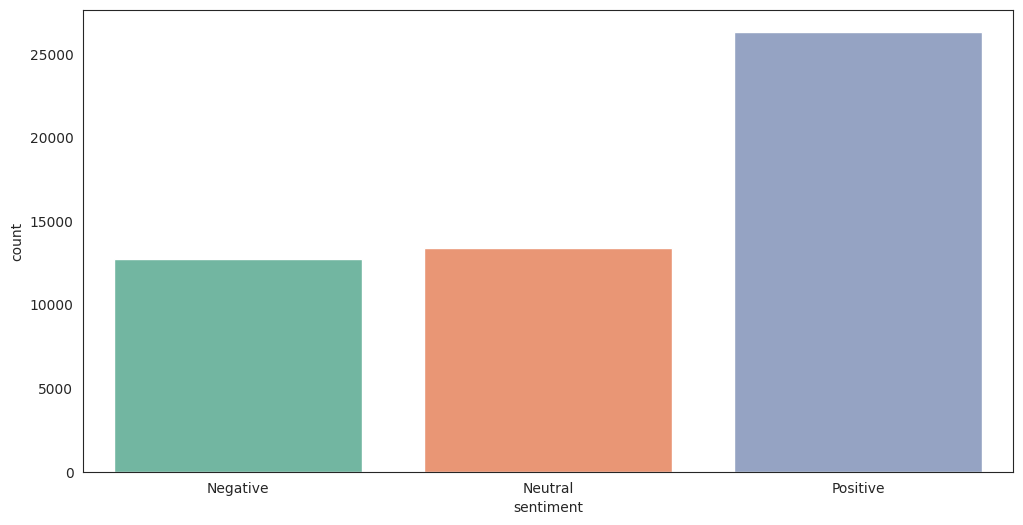

In [26]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

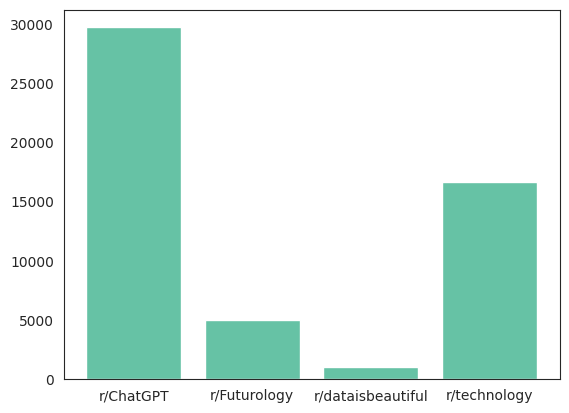

In [27]:
classes, class_counts = np.unique(df['subreddit'].to_numpy(), return_counts = True)
plt.bar(classes, class_counts)
plt.show()

<Figure size 1000x600 with 0 Axes>

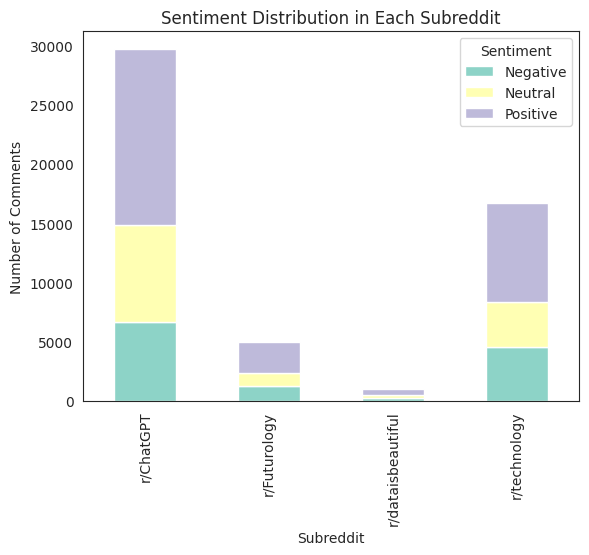

In [28]:
sentiment_counts = df.groupby(['subreddit', 'sentiment']).size().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.set_palette("Set3")
sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution in Each Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Number of Comments')
plt.legend(title='Sentiment', bbox_to_anchor=(1,1))
plt.show()

## Classifiers!!!
Here We come!!!

In [29]:
X = df['comment_body']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41929,), (10483,), (41929,), (10483,))

# Simple RNN

In [31]:
# using keras tokenizer
from keras.preprocessing import sequence, text
token = text.Tokenizer(num_words = None)
max_len = 1500

token.fit_on_texts(list(X_train))
x_train_seq = token.texts_to_sequences(X_train)


#zero pad the sequences, 
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen = max_len)

word_index = token.word_index


In [32]:

#%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         7389600   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 7429801 (28.34 MB)
Trainable params: 7429801 (28.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
#model.fit(x_train_pad, y_train, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

In [34]:
'''
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))
'''

'\nscores = model.predict(xvalid_pad)\nprint("Auc: %.2f%%" % (roc_auc(scores,yvalid)))\n'

In [35]:
'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.comment_body)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['sentiment'], random_state=42)
'''

"\nfrom sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer\n\nvectorizer = TfidfVectorizer(use_idf=True, lowercase=True)\nX_tf_idf= vectorizer.fit_transform(df.comment_body)\nx_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['sentiment'], random_state=42)\n"

In [36]:
'''
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_train and X_test are your feature matrices, and y_train is the target variable

# Step 1: Separate text and numerical columns
text_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['number']).columns

# Step 2: Impute NaN values for text data with an empty string and numerical data with 0
imputer_text = SimpleImputer(strategy='constant', fill_value='')
X_train_imputed_text = pd.DataFrame(imputer_text.fit_transform(X_train[text_cols]), columns=text_cols)
X_test_imputed_text = pd.DataFrame(imputer_text.transform(X_test[text_cols]), columns=text_cols)

imputer_numeric = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed_numeric = pd.DataFrame(imputer_numeric.fit_transform(X_train[numerical_cols]), columns=numerical_cols)
X_test_imputed_numeric = pd.DataFrame(imputer_numeric.transform(X_test[numerical_cols]), columns=numerical_cols)

# Step 3: Concatenate the imputed text and numerical data
X_train_imputed = pd.concat([X_train_imputed_text, X_train_imputed_numeric], axis=1)
X_test_imputed = pd.concat([X_test_imputed_text, X_test_imputed_numeric], axis=1)

# Step 4: Vectorize your text data
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))  # You can customize this based on your needs
X_train_vectorized = vectorizer.fit_transform(X_train_imputed[text_cols])
X_test_vectorized = vectorizer.transform(X_test_imputed[text_cols])

# Step 5: Train the Multinomial Naive Bayes model
MNB = MultinomialNB()
MNB.fit(X_train_vectorized, y_train)

# Step 6: Make predictions
predicted = MNB.predict(X_test_vectorized)
'''

"\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import CountVectorizer\n\n# Assuming X_train and X_test are your feature matrices, and y_train is the target variable\n\n# Step 1: Separate text and numerical columns\ntext_cols = X_train.select_dtypes(include=['object']).columns\nnumerical_cols = X_train.select_dtypes(include=['number']).columns\n\n# Step 2: Impute NaN values for text data with an empty string and numerical data with 0\nimputer_text = SimpleImputer(strategy='constant', fill_value='')\nX_train_imputed_text = pd.DataFrame(imputer_text.fit_transform(X_train[text_cols]), columns=text_cols)\nX_test_imputed_text = pd.DataFrame(imputer_text.transform(X_test[text_cols]), columns=text_cols)\n\nimputer_numeric = SimpleImputer(strategy='constant', fill_value=0)\nX_train_imputed_numeric = pd.DataFrame(imputer_numeric.fit_transform(X_train[numerical_c

In [37]:
df['comment_body']

0                   [ive, shock, day, now, ned, clickbait]
1        [angri, right, now, wast, time, read, post, su...
2        [chatgpt, karma, whore, folk, think, stream, t...
3                                          [work, me, ngl]
4              [certifi, must, moment, reali, shock, core]
                               ...                        
52410    [scari, thing, is, futur, text, won, t, trustw...
52411                             [read, to, thank, later]
52412                                         [mise, here]
52413                                 [chatgtp, think, to]
52414    [know, theyr, refer, to, section, sem, notewor...
Name: comment_body, Length: 52412, dtype: object

In [38]:
'''
corpus = [' '.join(comment) for comment in df['comment_body']]

# Create a tokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Create CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), tokenizer=token.tokenize)

# Fit and transform the corpus
text_counts = cv.fit_transform(corpus)
'''

"\ncorpus = [' '.join(comment) for comment in df['comment_body']]\n\n# Create a tokenizer\ntoken = RegexpTokenizer(r'[a-zA-Z0-9]+')\n\n# Create CountVectorizer\ncv = CountVectorizer(stop_words='english', ngram_range=(1, 1), tokenizer=token.tokenize)\n\n# Fit and transform the corpus\ntext_counts = cv.fit_transform(corpus)\n"

In [39]:
'''
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_train and X_test are your feature matrices, and y_train is the target variable

# Step 1: Handle NaN values in X_train and X_test
imputer = SimpleImputer(strategy='constant', fill_value='')  # You can use different strategies depending on your data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Vectorize your text data
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))  # You can customize this based on your needs
X_train_vectorized = vectorizer.fit_transform(X_train_imputed)
X_test_vectorized = vectorizer.transform(X_test_imputed)

# Step 3: Train the Multinomial Naive Bayes model
MNB = MultinomialNB()
MNB.fit(X_train_vectorized, y_train)

# Step 4: Make predictions
predicted = MNB.predict(X_test_vectorized)
'''

"\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import CountVectorizer\n\n# Assuming X_train and X_test are your feature matrices, and y_train is the target variable\n\n# Step 1: Handle NaN values in X_train and X_test\nimputer = SimpleImputer(strategy='constant', fill_value='')  # You can use different strategies depending on your data\nX_train_imputed = imputer.fit_transform(X_train)\nX_test_imputed = imputer.transform(X_test)\n\n# Step 2: Vectorize your text data\nvectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))  # You can customize this based on your needs\nX_train_vectorized = vectorizer.fit_transform(X_train_imputed)\nX_test_vectorized = vectorizer.transform(X_test_imputed)\n\n# Step 3: Train the Multinomial Naive Bayes model\nMNB = MultinomialNB()\nMNB.fit(X_train_vectorized, y_train)\n\n# Step 4: Make predictions\npredicted

In [40]:

'''MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)'''


'MNB = MultinomialNB()\nMNB.fit(X_train, y_train)\npredicted = MNB.predict(X_test)'

### Naive Bayes